##### Copyright 2023 The TF-Agents Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tutorial on Ranking in TF-Agents

### Get Started
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/ranking_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/ranking_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/ranking_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/ranking_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


### Setup

In [2]:
!pip install tf-agents[reverb]

  Using cached tf_agents-0.15.0-py3-none-any.whl (1.4 MB)


  Using cached pygame-2.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)


  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)


  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)


  Using cached tensorflow_probability-0.19.0-py2.py3-none-any.whl (6.7 MB)


  Using cached gym-0.23.0-py3-none-any.whl
  Using cached rlds-0.1.7-py3-none-manylinux2010_x86_64.whl (48 kB)


  Using cached dm_reverb-0.10.0-cp39-cp39-manylinux2014_x86_64.whl (6.3 MB)


  Using cached tensorflow-2.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)


  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)


  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)


  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached portpicker-1.5.2-py3-none-any.whl (14 kB)


  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)


  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0rc0


    Uninstalling tensorflow-estimator-2.12.0rc0:
      Successfully uninstalled tensorflow-estimator-2.12.0rc0


  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:


      Successfully uninstalled protobuf-3.20.3


  Attempting uninstall: keras
    Found existing installation: keras 2.12.0rc0


    Uninstalling keras-2.12.0rc0:
      Successfully uninstalled keras-2.12.0rc0


  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0


    Uninstalling tensorboard-2.12.0:
      Successfully uninstalled tensorboard-2.12.0


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.0rc0


    Uninstalling tensorflow-2.12.0rc0:


      Successfully uninstalled tensorflow-2.12.0rc0


In [3]:
#@title Imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tf_agents.bandits.agents import ranking_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import ranking_environment
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.policies import ranking_policy
from tf_agents.bandits.replay_buffers import bandit_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.metrics import tf_metrics
from tf_agents.specs import bandit_spec_utils
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory

2023-02-16 13:42:58.785052: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-16 13:42:58.785151: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-16 13:42:58.785160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# Introduction

In this tutorial, we guide you through the ranking algorithms implemented as part of the TF-Agents Bandits library. In a ranking problem, in every iteration an agent is presented with a set of items, and is tasked with ranking some or all of them to a list. This ranking decision then receives some form of feedback (maybe a user does or does not click on one or more of the selected items for example). The goal of the agent is to optimize some metric/reward with the goal of making better decisions over time.

# Prerequisites

The ranking algorithms in TF-Agents belong to a special type of bandit agents that operate on "per-arm" bandit problems. Hence, to be able to benefit the most from this tutorial, the reader should familiarize themselves with the [bandit](https://github.com/tensorflow/agents/tree/master/docs/tutorials/bandits_tutorial.ipynb) and the [per-arm bandit](https://github.com/tensorflow/agents/tree/master/docs/tutorials/per_arm_bandits_tutorial.ipynb) tutorials.

# The Ranking Problem and its Variants

For this tutorial, we will use the example of presenting items for sale to users. In every iteration, we receive a set of items and possibly a number describing how many of them we should display. We assume the number of items at hand is always greater than or equal to the number of slots to place them in. We need to fill the slots in the display to maximize the probability that the user will interact with one or more of the displayed items. The user, as well as the items, are described by *features*.

If we manage to put items on display that are liked by the user, the probability of user/item interactions increases. Hence, it's a good idea to learn how user-item pairs match. But how do we know if an item is liked by the user? To this end, we introduce *Feedback Types*.

#Feedback Types

As opposed to bandit problems where the feedback signal (the reward) is directly associated with a single chosen item, in ranking we need to consider how the feedback translates to the "goodness" of the displayed items. In other words, we need to assign scores to all or some of the displayed items. In our library we offer two different feedback types: *vector feedback* and *cascading feedback*.

## Vector Feedback

In the vector feedback type, we assume that the agent receives a scalar score for every item in the output ranking. These scalars are put together in a vector in the same ordering as the output ranking. Thus the feedback is a vector of the same size as the number of elements in the ranking.

This feedback type is quite straightforward in the sense that we don't need to worry about converting feedback signals to scores. On the other hand, the responsibility of scoring items falls on the designer (aka. you): it's up to the system designer to decide what scores to give based on the item, its position, and whether it was interacted with by the user.

##Cascading Feedback

In the cascading feedback type (the term coined by [Craswell et al., 2008](https://dl.acm.org/doi/abs/10.1145/1341531.1341545)), we assume the user looks at the displayed items in a sequential manner, starting at the top slot. As soon as the user finds an item worthy of clicking, they click and never return to the current ranked list. They don't even look at items below the item clicked. Not clicking on any item is also a possibility, this happens when none of the displayed items are worthy of clicking. In this case, the user does look at all the items.

The feedback signal is composed of two elements: The index of the chosen element, and the value of the click. Then it is the agent's task to translate this information to scores. In our implementation in the bandit library, we implemented the convention that seen but unclicked items receive some low score (typically 0 or -1), the clicked item receives the click value, and the items beyond the clicked one are ignored by the agent.

# Diversity and Exploration

To maximize the chances of the user clicking on an item, it's not enough to just choose the highest scoring items and put them high in the ranking. For a user with a lot of different interests, they might be most interested in sports, but they also like arts and traveling. Giving all the sporty items the highest estimated scores and displaying all sporty items in the highest slots may not be optimal. The user might be in the mood for arts or traveling. Hence, it is a good idea to display a mix of the high-scoring interests. It is important to not only maximize the score of the displayed items but also make sure they form a diverse set.

As with other limited-information learning problems (like bandits), it is also important to keep in mind that our decisions not only affect the immediate reward, but also the training data and future reward. If we always only display items based on their current estimated score, we might be missing out on high-scoring items that we haven't explored enough yet, and thus we are not aware of how good they are. That is, we need to incorporate exploration to our decision making process.

All of the above concepts and considerations are addressed in our library. In this tutorial we walk you through the details.

# Simulating Users: Our Test Environment

Let's dive into our codebase!

First we define the environment, the class responsible for randomly generating user and item features, and give feedback after decisions.

In [4]:
feedback_model = ranking_environment.FeedbackModel.CASCADING #@param["ranking_environment.FeedbackModel.SCORE_VECTOR", "ranking_environment.FeedbackModel.CASCADING"] {type:"raw"}


We also need a model for the environment to decide when to *not click*. We have two ways in our library, *distance based* and *ghost actions*.


*   In distance based, if the user features are not close enough to any of the item features, the user does not click.
*   In the ghost actions model, we set up extra imaginary actions in the form of unit vector item features. If the user chooses one of the ghost actions, it results in a no-click.



In [5]:
click_type = "ghost_actions"  #@param["distance_based", "ghost_actions"]
click_model = (ranking_environment.ClickModel.DISTANCE_BASED
               if click_type == "distance_based" else
               ranking_environment.ClickModel.GHOST_ACTIONS)

We are almost ready to define the ranking environment, just a couple of preparations: we define the sampling functions for the global (user) and the item features. These features will be used by the environment to simulate user behavior: a weighted inner product of the global and item features is calculated, and the probability of the user clicking is proportional to the inner product values. The weighting of the inner product is defined by `scores_weight_matrix` below.

In [6]:
global_dim = 9  #@param{ type: "integer"}
item_dim   = 11  #@param{ type: "integer"}
num_items  = 50 #@param{ type: "integer"}
num_slots  = 3  #@param{ type: "integer"}
distance_threshold = 5.0  #@param{ type: "number" }
batch_size = 128   #@param{ type: "integer"}

def global_sampling_fn():
  return np.random.randint(-1, 1, [global_dim]).astype(np.float32)

def item_sampling_fn():
  return np.random.randint(-2, 3, [item_dim]).astype(np.float32)

# Inner product with excess dimensions ignored.
scores_weight_matrix = np.eye(11, 9, dtype=np.float32)

env = ranking_environment.RankingPyEnvironment(
    global_sampling_fn,
    item_sampling_fn,
    num_items=num_items,
    num_slots=num_slots,
    scores_weight_matrix=scores_weight_matrix,
    feedback_model=feedback_model,
    click_model=click_model,
    distance_threshold=distance_threshold,
    batch_size=batch_size)

# Convert the python environment to tf environment.
environment = tf_py_environment.TFPyEnvironment(env)

Now let's define a few different agents that will tackle the above environment! All of the agents train a network that estimates scores of item/user pairs. The difference lies in the policy, that is, how the trained network is used to make a ranking decision. The implemented policies span from just stack ranking based on scores to taking into account diversity and exploration with the ability to tune the mixture of these aspects.

In [7]:
#@title Defining the Network and Training Params
scoring_network = (
      global_and_arm_feature_network.create_feed_forward_common_tower_network(
          environment.observation_spec(), (20, 10), (20, 10), (20, 10)))
learning_rate = 0.005  #@param{ type: "number"}

feedback_dict = {ranking_environment.FeedbackModel.CASCADING: ranking_agent.FeedbackModel.CASCADING,
                 ranking_environment.FeedbackModel.SCORE_VECTOR: ranking_agent.FeedbackModel.SCORE_VECTOR}
agent_feedback_model = feedback_dict[feedback_model]

In [8]:
#@title Stack Ranking Deterministically by Scores

policy_type = ranking_agent.RankingPolicyType.DESCENDING_SCORES
descending_scores_agent = ranking_agent.RankingAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    scoring_network=scoring_network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    feedback_model=agent_feedback_model,
    policy_type=policy_type,
    summarize_grads_and_vars=True)

In [9]:
#@title Sampling Sequentially Based on Scores

policy_type = ranking_agent.RankingPolicyType.NO_PENALTY
logits_temperature = 1.0  #@param{ type: "number" }

no_penalty_agent = ranking_agent.RankingAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    scoring_network=scoring_network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    feedback_model=agent_feedback_model,
    policy_type=policy_type,
    logits_temperature=logits_temperature,
    summarize_grads_and_vars=True)

In [10]:
#@title Sampling Sequentally and Taking Diversity into Account
#@markdown The balance between ranking based on scores and taking diversity into account is governed by the following "penalty mixture" parameter. A low positive value results in rankings that hardly mix in diversity, a higher value will enforce more diversity.

policy_type = ranking_agent.RankingPolicyType.COSINE_DISTANCE
penalty_mixture = 1.0 #@param{ type: "number"}

cosine_distance_agent = ranking_agent.RankingAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    scoring_network=scoring_network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    feedback_model=agent_feedback_model,
    policy_type=policy_type,
    logits_temperature=logits_temperature,
    penalty_mixture_coefficient=penalty_mixture,
    summarize_grads_and_vars=True)



In [11]:
#@title Choosing the desired agent.
agent_type = "cosine_distance_agent" #@param["cosine_distance_agent", "no_penalty_agent", "descending_scores_agent"]
if agent_type == "descending_scores_agent":
  agent = descending_scores_agent
elif agent_type == "no_penalty_agent":
  agent = no_penalty_agent
else:
  agent = cosine_distance_agent

Before we can start our training loop, there is one more thing we need to take care of, concerning the training data.

The arm features presented to the policy at decision time contains all items that the policy can choose from. However, at training, we need the features of items that were selected, and for convenience, in the order of the decision output. To this end, the following function is used (copied here for clarity from [here](https://github.com/tensorflow/agents/tree/master/tf_agents/bandits/agents/examples/v2/train_eval_ranking.py).

In [12]:
def order_items_from_action_fn(orig_trajectory):
  """Puts the features of the selected items in the recommendation order.

  This function is used to make sure that at training the item observation is
  filled with features of items selected by the policy, in the order of the
  selection. Features of unselected items are discarded.

  Args:
    orig_trajectory: The trajectory as output by the policy

  Returns:
    The modified trajectory that contains slotted item features.
  """
  item_obs = orig_trajectory.observation[
      bandit_spec_utils.PER_ARM_FEATURE_KEY]
  action = orig_trajectory.action
  if isinstance(
      orig_trajectory.observation[bandit_spec_utils.PER_ARM_FEATURE_KEY],
      tensor_spec.TensorSpec):
    dtype = orig_trajectory.observation[
        bandit_spec_utils.PER_ARM_FEATURE_KEY].dtype
    shape = [
        num_slots, orig_trajectory.observation[
            bandit_spec_utils.PER_ARM_FEATURE_KEY].shape[-1]
    ]
    new_observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            orig_trajectory.observation[bandit_spec_utils.GLOBAL_FEATURE_KEY],
        bandit_spec_utils.PER_ARM_FEATURE_KEY:
            tensor_spec.TensorSpec(dtype=dtype, shape=shape)
    }
  else:
    slotted_items = tf.gather(item_obs, action, batch_dims=1)
    new_observation = {
        bandit_spec_utils.GLOBAL_FEATURE_KEY:
            orig_trajectory.observation[bandit_spec_utils.GLOBAL_FEATURE_KEY],
        bandit_spec_utils.PER_ARM_FEATURE_KEY:
            slotted_items
    }
  return trajectory.Trajectory(
      step_type=orig_trajectory.step_type,
      observation=new_observation,
      action=(),
      policy_info=(),
      next_step_type=orig_trajectory.next_step_type,
      reward=orig_trajectory.reward,
      discount=orig_trajectory.discount)

In [13]:
#@title Defininfing Parameters to Run the Agent on the Defined Environment
num_iterations = 400 #@param{ type: "number" }
steps_per_loop = 2   #@param{ type: "integer" }

As in the bandit tutorials, we define the replay buffer that will feed the agent the samples to train on. Then, we use the driver to put everything together: The environment provides features, the policy chooses rankings, and samples are collected to be trained on.

In [14]:
replay_buffer = bandit_replay_buffer.BanditReplayBuffer(
      data_spec=order_items_from_action_fn(agent.policy.trajectory_spec),
      batch_size=batch_size,
      max_length=steps_per_loop)

if feedback_model == ranking_environment.FeedbackModel.SCORE_VECTOR:
  reward_metric = tf_metrics.AverageReturnMetric(
      batch_size=environment.batch_size,
      buffer_size=200)
else:
  reward_metric = tf_metrics.AverageReturnMultiMetric(
        reward_spec=environment.reward_spec(),
        batch_size=environment.batch_size,
        buffer_size=200)

add_batch_fn = lambda data: replay_buffer.add_batch(
        order_items_from_action_fn(data))

observers = [add_batch_fn, reward_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * batch_size,
    observers=observers)

reward_values = []

for _ in range(num_iterations):
  driver.run()
  loss_info = agent.train(replay_buffer.gather_all())
  replay_buffer.clear()
  if feedback_model == ranking_environment.FeedbackModel.SCORE_VECTOR:
    reward_values.append(reward_metric.result())
  else:
    reward_values.append(reward_metric.result())


Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Distribution subclass PenalizedPlackettLuce inherits `_parameter_properties from its parent (PlackettLuce)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['scores']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**base_class_params)
  

Let's plot the reward!

Text(0.5, 0, 'Number of Iterations')

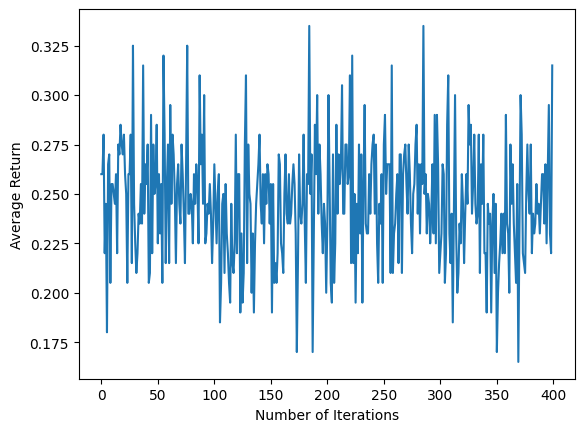

In [15]:
if feedback_model == ranking_environment.FeedbackModel.SCORE_VECTOR:
  reward = reward_values
else:
  reward = [r["chosen_value"] for r in reward_values]
plt.plot(reward)
plt.ylabel('Average Return')
plt.xlabel('Number of Iterations')

# What's Next?

This tutorial has lots of tunable parameters, including the policy/agent to use, some properties of the environment, and even the feedback model. Feel free to experiment with those parameters!

There is also a ready-to-run example for ranking in `tf_agents/bandits/agents/examples/v2/train_eval_ranking.py`